In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd=''
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

# 1. 以純財務資料建立最小可行性模型

# 取 X值 (20183-20211) 財務數據

In [2]:
company_factor = get_data("""SELECT 
                            net_profit_rate,
                            operating_gross_rate, 
                            roe_rate,
                            roa_rate,
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            cash_reinvest_rate
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

#稅後淨利率 #營業毛利率 #流動比率 #速動比率 #負債比率 #應收帳款週轉率  #現金再投資比率 #董監事持股比利 
#董監事質押比利 #外資持股比例 # >1000張大股東持股比率 # <400張股東持股比率
#平均持股張數

                            
                            
company_factor

C:\Users\Tibame\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


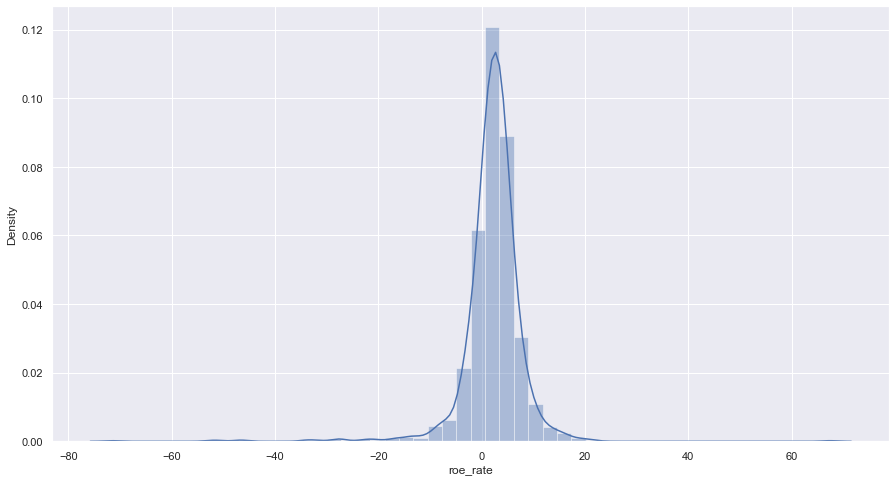

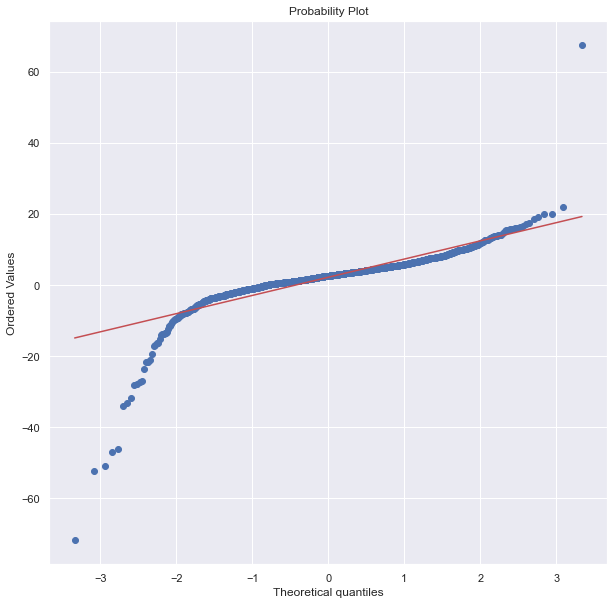

In [29]:
#histogram and normal probability plot
from scipy import stats
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(company_factor['roe_rate']);
fig = plt.figure(figsize=(10,10))
res = stats.probplot(company_factor['roe_rate'], plot=plt)

C:\Users\Tibame\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='roe_rate'>

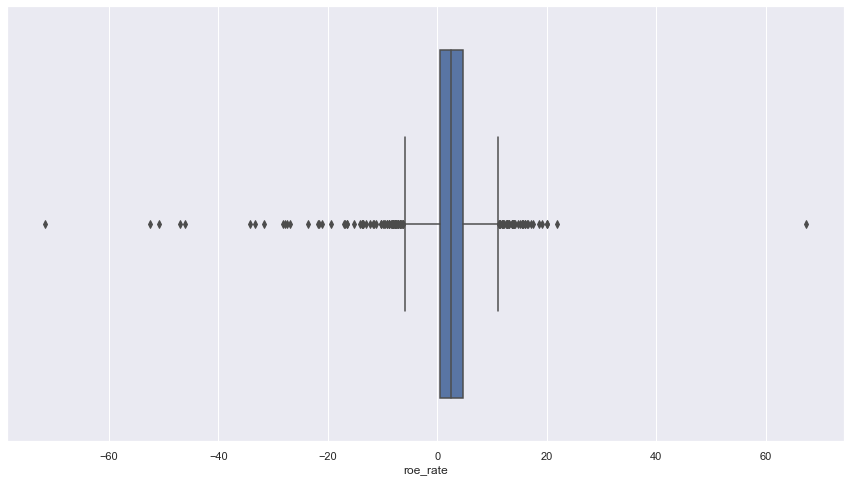

In [30]:
sns.boxplot(company_factor['roe_rate'])

# 取 Y值 (20184-20212)

In [4]:
Roe_rul = get_data("""SELECT roe_rate
                      FROM tfb103d_project.datamining_alldata_afetl
                      WHERE stock_report_date > '20183';""",'tfb103d_project')
Roe_rul

,roe_rate
0,0.42
1,-0.20
2,0.85
3,0.17
4,-0.80
...,...
1634,4.01
1635,6.07
1636,11.76
1637,4.71


<h1>資料前處理

In [5]:
#缺值檢視
company_factor.isnull().sum()
Roe_rul.isnull().sum()

roe_rate    0
dtype: int64

In [6]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [7]:
#定義股東權益報酬率 >平均者為表現良好
m2 = Roe_rul['roe_rate'].mean()
Roe_rul['roe_rate1'] = Roe_rul.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [8]:
X = company_factor

y = Roe_rul['roe_rate1']

print("x.shape: " ,X.shape)
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())

x.shape:  (1639, 9)
y.shape:  (1639,)
y.sum(): 884


<h3>ROE:  755 筆標記為 0 ； 884 筆為 1

In [10]:
# 輸入數據調成標準值以免各特徵影響不同
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\Tibame\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


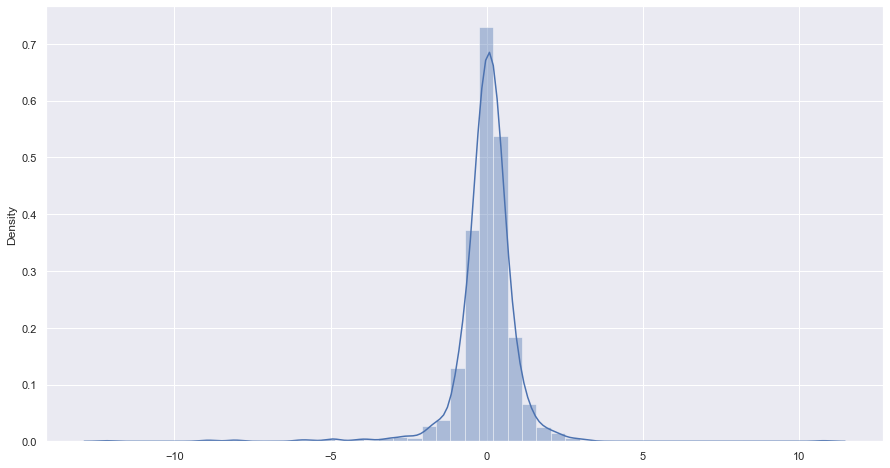

In [32]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.distplot(X_scaled[:,2]);

C:\Users\Tibame\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

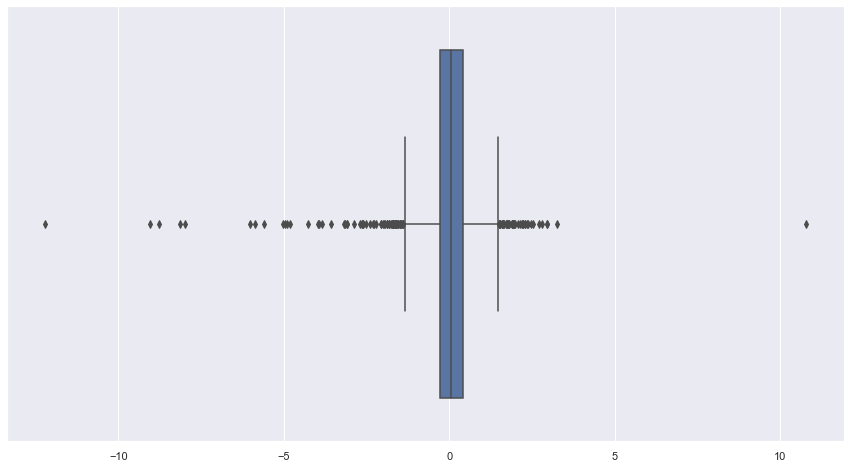

In [31]:
sns.boxplot(X_scaled[:,2])

In [13]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 9


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
print(tf.__version__)

2.6.0


In [15]:
# 建立 DNN模型 for ROE 預測
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________


In [291]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

pred = model.predict(X_test)

# 四捨五入得到 0,1
# 將預測值從(N,1)壓扁成 (N,) 
P = np.round(pred).flatten()

Epoch 1/50
41/41 [==============================] - 1s 4ms/step - loss: 0.6739 - accuracy: 0.6049 - val_loss: 0.5570 - val_accuracy: 0.7774
Epoch 2/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5610 - accuracy: 0.7353 - val_loss: 0.4960 - val_accuracy: 0.7957
Epoch 3/50
41/41 [==============================] - 0s 1ms/step - loss: 0.5335 - accuracy: 0.7803 - val_loss: 0.4791 - val_accuracy: 0.8049
Epoch 4/50
41/41 [==============================] - 0s 1ms/step - loss: 0.4949 - accuracy: 0.8002 - val_loss: 0.4720 - val_accuracy: 0.7988
Epoch 5/50
41/41 [==============================] - 0s 1ms/step - loss: 0.4955 - accuracy: 0.7864 - val_loss: 0.4678 - val_accuracy: 0.8018
Epoch 6/50
41/41 [==============================] - 0s 1ms/step - loss: 0.4954 - accuracy: 0.7803 - val_loss: 0.4674 - val_accuracy: 0.8018
Epoch 7/50
41/41 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7986 - val_loss: 0.4634 - val_accuracy: 0.8049
Epoch 8/50
41/41 [==

In [292]:
# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))
print("f1_score:",f1_score(y_test, P))

41/41 [==============================] - 0s 588us/step - loss: 0.3815 - accuracy: 0.8406
Train score: [0.3814779818058014, 0.8405796885490417]
11/11 [==============================] - 0s 598us/step - loss: 0.4445 - accuracy: 0.8140
Test score: [0.4445402920246124, 0.8140243887901306]
f1_score: 0.8355795148247979


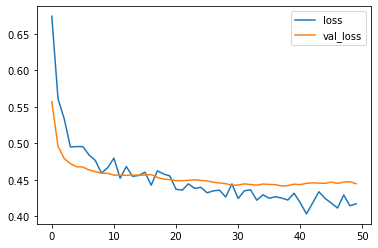

In [293]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

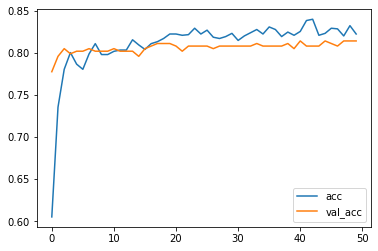

In [294]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [288]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[112,  36],
       [ 24, 156]], dtype=int64)

# 2.分批加入 環境因素 檢視模型預測能力

In [196]:
#取得需要的特徵
addenv_factor2 = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

addenv_factor2 = addenv_factor2.drop(["stock_code","stock_report_date"],axis = 1 )

addenv_factor2

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,1.07,0.91,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,0.42,0.37,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,-0.20,-0.14,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,0.85,0.74,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,0.17,0.17,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-0.03,6.29,4.71,...,378,22722,18682,71220,2776,95038,1818.75,5251.16,6.72,0.00
1635,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,4.01,2.97,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1636,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,6.07,4.61,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1637,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,11.76,8.79,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29


In [197]:
X2 = addenv_factor2

y1 = Roe_rul['roe_rate1']
print("X2.shape: " ,X2.shape)
print("y1.shape: " ,y1.shape)
print('y1.sum():',y1.sum())

X2.shape:  (1639, 61)
y1.shape:  (1639,)
y1.sum(): 884


In [25]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [26]:
X2_scaled = pd.DataFrame()
a, b = X2.shape

for i in range(b):
    x2_new = mean_norm(X2[X2.columns[i]])
    X2_scaled.insert(i,X2.columns[i],x2_new)
X2_scaled

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,roe_rate,roa_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,0.310530,0.214147,0.195944,-0.553189,-0.513366,-0.818028,-0.161824,-0.205327,-0.182515,-0.220846,...,1.373233,-1.970904,-0.906099,-1.108827,0.353536,1.099460,-0.625915,-0.552314,-0.874567,-0.322412
1,0.420361,0.060193,-0.294623,-0.520781,-0.494960,-0.898471,-0.064074,-0.239816,-0.290044,-0.381183,...,0.645715,-1.007964,2.049630,-0.080664,-0.027240,1.817215,-0.625915,-0.552314,-0.874567,-0.322412
2,0.272657,-0.095466,-0.436961,-0.507650,-0.496387,-0.926863,-0.379883,-0.225158,-0.392611,-0.532612,...,-1.000772,-1.490323,-1.252516,-0.754698,1.438532,-0.423973,-0.625915,-0.552314,-0.874567,-0.322412
3,0.085944,0.155633,-0.335329,-0.500379,-0.482945,-0.912075,-0.284953,-0.168251,-0.218909,-0.271322,...,-0.675303,-0.090814,-0.457379,-0.588868,0.798135,-0.154426,-0.625915,-0.552314,-0.874567,-0.322412
4,-0.039793,0.004708,-0.442476,-0.512620,-0.477102,-0.863573,-0.181562,0.017126,-0.331402,-0.440567,...,-0.426416,0.163481,-0.419705,0.746536,0.922537,-1.356062,-0.625915,-0.552314,-0.874567,-0.322412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,0.240658,0.719600,-0.102197,-0.251399,-0.372635,-0.285892,-0.357940,0.681029,0.907451,...,0.320247,1.151762,-0.796139,-0.793339,0.088507,-0.711134,-0.588310,-0.478457,1.381120,-0.322412
1635,-0.192042,0.167942,0.016839,-0.174049,-0.299321,-0.254929,-0.070653,0.204228,0.303849,0.390810,...,2.158186,0.311078,0.694283,-0.386217,-0.941320,-0.934054,-0.083800,-0.241950,0.582231,-0.322412
1636,-0.273468,0.253157,-0.368156,-0.005312,-0.137752,-0.496257,0.109809,0.097313,0.644634,0.877759,...,0.013924,0.663179,-0.035307,-0.247208,-2.363822,-0.428265,0.408293,-0.164609,0.491601,-0.322412
1637,-0.256804,0.519405,-0.336905,-0.127359,-0.166362,-0.352525,0.290272,0.617232,1.585929,2.118886,...,-0.445561,1.157097,1.600605,0.956559,-0.524846,0.656285,2.160336,2.228015,1.488534,-0.259081


In [27]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X2_train, X2_test, y1_train, y1_test = train_test_split(X2_scaled, y1, test_size=0.2,random_state=1)
N, D = X2_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 61


In [1]:
# 輸入數據調成標準值以免各特徵影響不同
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

# 以迴圈處理

In [ ]:
import_list = addenv_factor2.columns[11:]
result_list = []
for item in import_list:
    Xt = addenv_factor2[['net_profit_rate',
                        'operating_gross_rate', 
                        'roe_rate',
                        'roa_rate',
                        'current_rate', 
                        'quick_rate',  
                        'debt_rate',  
                        'receivables_turnover_rate', 
                        'cash_reinvest_rate',
                        item
                        ]]

    y1 = Roe_rul['roe_rate1']

    Xt_scaled = pd.DataFrame()
    a, b = Xt.shape

    for i in range(b):
        xt_new = mean_norm(Xt[Xt.columns[i]])
        Xt_scaled.insert(i,Xt.columns[i],xt_new)


    #分割資料為 測試集 與 訓練集
    Xt_train, Xt_test, y1_train, y1_test = train_test_split(Xt_scaled, y1, test_size=0.2, random_state=1)
    N, D = Xt_train.shape

    for i in range(1,6):
        
        # 建立 DNN 模型
        modelt = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(D,)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.6),
          tf.keras.layers.Dense(16, activation='relu'),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(1, activation='sigmoid')
          ])

        #編譯模型
        modelt.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

#         modelt.summary()

        # 訓練模型
        rt = modelt.fit(Xt_train, y1_train, validation_data=(Xt_test, y1_test), epochs=50, verbose = 0 )
        pred = modelt.predict(Xt_test)
        P = np.round(pred).flatten()
        tmp = [str(item)]
        tmp.extend(modelt.evaluate(Xt_train, y1_train))
        tmp.extend(modelt.evaluate(Xt_test, y1_test))
        tmp.append(f1_score(y1_test, P))

        # 評估模型 - evaluate() returns loss and accuracy
        print("Train score:", modelt.evaluate(Xt_train, y1_train))
        print("Test score:", modelt.evaluate(Xt_test, y1_test))
        print("f1_score:",f1_score(y1_test, P))
        result_list.append(tmp)

#         plt.plot(rt.history['loss'], label='loss')
#         plt.plot(rt.history['val_loss'], label='val_loss')
#         plt.legend()
#         plt.savefig(f'./results/pre1_loss_{import_list[item]}_{i}.png')#儲存圖片
#         plt.show() 

#         plt.plot(rt.history['accuracy'], label='acc')
#         plt.plot(rt.history['val_accuracy'], label='val_acc')
#         plt.legend()
#         plt.savefig(f'./results/pre1_accuracy_{import_list[item]}_{i}.png')#儲存圖片
#         plt.show() 

result_pd = pd.DataFrame(result_list,columns=["item","train_loss","train_accuracy","test_loss","test_accuracy","F1_score"])
result_pd.to_csv("./results/all_factor_test.csv")

In [35]:
all_factor_test = pd.read_csv("./results/all_factor_test.csv")
all_factor_test

,item,train_loss,train_accuracy,test_loss,test_accuracy,F1_score
0,avg_director_rate,0.387345,0.839054,0.445520,0.817073,0.836066
1,avg_director_rate,0.379000,0.841343,0.433423,0.814024,0.837333
2,avg_director_rate,0.383422,0.840580,0.437525,0.810976,0.835106
3,avg_director_rate,0.385504,0.839817,0.441390,0.810976,0.832432
4,avg_director_rate,0.385352,0.838291,0.438980,0.807927,0.829268
...,...,...,...,...,...,...
245,people_fully_vaccinated_per_hundred_USA,0.381778,0.835240,0.439268,0.820122,0.840108
246,people_fully_vaccinated_per_hundred_USA,0.386030,0.833715,0.442627,0.817073,0.837838
247,people_fully_vaccinated_per_hundred_USA,0.380850,0.835240,0.435353,0.814024,0.838196
248,people_fully_vaccinated_per_hundred_USA,0.384406,0.839817,0.445491,0.820122,0.839237


In [82]:
all_factor_group = all_factor_test.sort_values(['test_accuracy'],ascending=False).groupby(['item']).aggregate(['mean'])
all_factor_group

,train_loss,train_accuracy,test_loss,test_accuracy,F1_score
,mean,mean,mean,mean,mean
item,,,,,
BCI,0.381383,0.838139,0.451020,0.806707,0.827569
BDI,0.380731,0.837529,0.450271,0.807317,0.827691
N1NG,0.374036,0.844851,0.439928,0.813415,0.836371
avg_board_bys,0.380156,0.840580,0.437906,0.811585,0.831201
avg_director_pledge_rate,0.383744,0.836003,0.441177,0.812195,0.829855
avg_director_rate,0.384125,0.839817,0.439367,0.812195,0.834041
avg_export_rate,0.374693,0.840580,0.447505,0.823171,0.842884
avg_import_rate,0.376115,0.840732,0.446412,0.823780,0.842479


In [347]:
top10_acc = all_factor_group['test_accuracy'].sort_values(by=['mean'],ascending=False).head(25)
top10_acc

,mean
item,
export_usd_value_381800,0.828049
new_cases_smoothed_TWN,0.825610
import_usd_value_37079090,0.825000
avg_import_rate,0.823780
avg_export_rate,0.823171
export_usd_value_37050000306,0.822561
export_kgm_weight_37079090,0.821951
export_usd_value_2804,0.821341
import_usd_value_381800,0.820732


In [92]:
top10_f1 = all_factor_group['F1_score'].sort_values(by=['mean'],ascending=False).head(10)
top10_f1

,mean
item,
export_usd_value_381800,0.848357
new_cases_smoothed_TWN,0.846064
import_usd_value_37079090,0.844421
avg_export_rate,0.842884
import_usd_value_381800,0.842549
avg_import_rate,0.842479
export_kgm_weight_37079090,0.842316
new_cases_smoothed_OWID_EUR,0.841070
export_usd_value_37050000306,0.840888


In [97]:
results = []
for item in all_factor_group.index:
    if item in (top10_acc.index & top10_f1.index):
        results.append(item)
results

<ipython-input-97-384704f50a6d>:3: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if item in (top10_acc.index & top10_f1.index):


['avg_export_rate',
 'avg_import_rate',
 'export_kgm_weight_37079090',
 'export_usd_value_2804',
 'export_usd_value_37050000306',
 'export_usd_value_381800',
 'import_usd_value_37079090',
 'import_usd_value_381800',
 'new_cases_smoothed_OWID_EUR',
 'new_cases_smoothed_TWN']

In [131]:
company_factor_f = get_data("""SELECT 
                            net_profit_rate,
                            operating_gross_rate, 
                            roe_rate,
                            roa_rate,
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            cash_reinvest_rate,
                            export_usd_value_381800

                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

                            
#                             avg_export_rate
#                             export_kgm_weight_37079090,
#                             export_usd_value_2804,
#                             export_usd_value_37050000306,
#                             new_cases_smoothed_OWID_EUR,
#                             import_usd_value_381800
#                             import_usd_value_37079090,
#                             avg_import_rate
#                             new_cases_smoothed_TWN
company_factor_f

,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,export_usd_value_381800
0,13.35,38.03,1.07,0.91,154.53,103.70,18.22,3.31,1.74,107270
1,5.22,40.93,0.42,0.37,166.92,110.41,16.86,4.35,1.34,112119
2,-3.00,37.03,-0.20,-0.14,171.94,109.89,16.38,0.99,1.51,96978
3,10.26,32.10,0.85,0.74,174.72,114.79,16.63,2.00,2.17,98799
4,2.29,28.78,0.17,0.17,170.04,116.92,17.45,3.10,4.32,90681
...,...,...,...,...,...,...,...,...,...,...
1634,14.75,30.43,6.29,4.71,326.95,199.20,25.75,1.99,-0.03,95038
1635,10.91,24.76,4.01,2.97,299.48,181.73,27.74,4.28,6.49,93532
1636,15.41,22.61,6.07,4.61,363.99,240.63,23.66,6.20,5.25,96949
1637,29.47,23.05,11.76,8.79,317.33,230.20,26.09,8.12,11.28,104276


In [132]:
X = company_factor_f

y = Roe_rul['roe_rate1']

print("x.shape: " ,X.shape)
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())

x.shape:  (1639, 10)
y.shape:  (1639,)
y.sum(): 884


<h3>ROE:  755 筆標記為 0 ； 884 筆為 1

In [133]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [134]:
X_scaled = pd.DataFrame()
a, b = X.shape

for i in range(b):
    X_new = mean_norm(X[X.columns[i]])
    X_scaled.insert(i,X.columns[i],X_new)
X_scaled

,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,export_usd_value_381800
0,0.214147,0.310530,-0.182515,-0.220846,-0.553189,-0.513366,-0.818028,-0.161824,-0.205327,1.099460
1,0.060193,0.420361,-0.290044,-0.381183,-0.520781,-0.494960,-0.898471,-0.064074,-0.239816,1.817215
2,-0.095466,0.272657,-0.392611,-0.532612,-0.507650,-0.496387,-0.926863,-0.379883,-0.225158,-0.423973
3,0.155633,0.085944,-0.218909,-0.271322,-0.500379,-0.482945,-0.912075,-0.284953,-0.168251,-0.154426
4,0.004708,-0.039793,-0.331402,-0.440567,-0.512620,-0.477102,-0.863573,-0.181562,0.017126,-1.356062
...,...,...,...,...,...,...,...,...,...,...
1634,0.240658,0.022697,0.681029,0.907451,-0.102197,-0.251399,-0.372635,-0.285892,-0.357940,-0.711134
1635,0.167942,-0.192042,0.303849,0.390810,-0.174049,-0.299321,-0.254929,-0.070653,0.204228,-0.934054
1636,0.253157,-0.273468,0.644634,0.877759,-0.005312,-0.137752,-0.496257,0.109809,0.097313,-0.428265
1637,0.519405,-0.256804,1.585929,2.118886,-0.127359,-0.166362,-0.352525,0.290272,0.617232,0.656285


In [135]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 10


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
print(tf.__version__)

2.6.0


In [187]:
# 建立TF模型 for 淨利
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#編譯模型
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [188]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               1408      
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 33        
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


In [207]:
# 訓練模型
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000)

pred = model.predict(X_test)

# 四捨五入得到 0,1
# 將預測值從(N,1)壓扁成 (N,) 
P = np.round(pred).flatten()

Epoch 1/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4548 - accuracy: 0.8230 - val_loss: 0.4475 - val_accuracy: 0.8262
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4606 - accuracy: 0.8154 - val_loss: 0.4468 - val_accuracy: 0.8293
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.8185 - val_loss: 0.4467 - val_accuracy: 0.8232
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4620 - accuracy: 0.8253 - val_loss: 0.4478 - val_accuracy: 0.8293
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4454 - accuracy: 0.8200 - val_loss: 0.4464 - val_accuracy: 0.8293
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4509 - accuracy: 0.8307 - val_loss: 0.4470 - val_accuracy: 0.8201
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4483 - accuracy: 0.8284 - val_loss: 0.4474 - val_accuracy: 0.8262
Epoch 

41/41 [==============================] - 0s 1ms/step - loss: 0.4041 - accuracy: 0.8368 - val_loss: 0.4411 - val_accuracy: 0.8232
Epoch 116/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4101 - accuracy: 0.8322 - val_loss: 0.4390 - val_accuracy: 0.8232
Epoch 117/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3896 - accuracy: 0.8322 - val_loss: 0.4369 - val_accuracy: 0.8171
Epoch 118/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4003 - accuracy: 0.8261 - val_loss: 0.4372 - val_accuracy: 0.8232
Epoch 119/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3973 - accuracy: 0.8284 - val_loss: 0.4394 - val_accuracy: 0.8293
Epoch 120/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4082 - accuracy: 0.8398 - val_loss: 0.4413 - val_accuracy: 0.8262
Epoch 121/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4208 - accuracy: 0.8383 - val_loss: 0.4409 - val_accuracy: 0.8201
Epoch 1

Epoch 172/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3955 - accuracy: 0.8307 - val_loss: 0.4437 - val_accuracy: 0.8232
Epoch 173/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3961 - accuracy: 0.8276 - val_loss: 0.4438 - val_accuracy: 0.8262
Epoch 174/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3970 - accuracy: 0.8345 - val_loss: 0.4454 - val_accuracy: 0.8232
Epoch 175/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3880 - accuracy: 0.8314 - val_loss: 0.4471 - val_accuracy: 0.8232
Epoch 176/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4011 - accuracy: 0.8368 - val_loss: 0.4464 - val_accuracy: 0.8201
Epoch 177/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.4002 - accuracy: 0.8345 - val_loss: 0.4477 - val_accuracy: 0.8232
Epoch 178/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.3942 - accuracy: 0.8299 - val_loss: 0.4460 - val_accuracy:

Epoch 229/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3918 - accuracy: 0.8330 - val_loss: 0.4509 - val_accuracy: 0.8171
Epoch 230/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3869 - accuracy: 0.8352 - val_loss: 0.4519 - val_accuracy: 0.8171
Epoch 231/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3868 - accuracy: 0.8452 - val_loss: 0.4547 - val_accuracy: 0.8201
Epoch 232/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4030 - accuracy: 0.8223 - val_loss: 0.4534 - val_accuracy: 0.8232
Epoch 233/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4021 - accuracy: 0.8223 - val_loss: 0.4549 - val_accuracy: 0.8201
Epoch 234/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3895 - accuracy: 0.8330 - val_loss: 0.4578 - val_accuracy: 0.8201
Epoch 235/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3895 - accuracy: 0.8391 - val_loss: 0.4567 - val_accuracy:

Epoch 286/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3913 - accuracy: 0.8436 - val_loss: 0.4546 - val_accuracy: 0.8201
Epoch 287/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3962 - accuracy: 0.8375 - val_loss: 0.4551 - val_accuracy: 0.8201
Epoch 288/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8467 - val_loss: 0.4563 - val_accuracy: 0.8232
Epoch 289/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3720 - accuracy: 0.8429 - val_loss: 0.4579 - val_accuracy: 0.8232
Epoch 290/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3871 - accuracy: 0.8368 - val_loss: 0.4551 - val_accuracy: 0.8232
Epoch 291/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3801 - accuracy: 0.8375 - val_loss: 0.4529 - val_accuracy: 0.8201
Epoch 292/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3920 - accuracy: 0.8322 - val_loss: 0.4526 - val_accuracy:

Epoch 343/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3832 - accuracy: 0.8421 - val_loss: 0.4557 - val_accuracy: 0.8110
Epoch 344/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3843 - accuracy: 0.8360 - val_loss: 0.4584 - val_accuracy: 0.8171
Epoch 345/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3825 - accuracy: 0.8429 - val_loss: 0.4599 - val_accuracy: 0.8110
Epoch 346/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3814 - accuracy: 0.8413 - val_loss: 0.4625 - val_accuracy: 0.8110
Epoch 347/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3999 - accuracy: 0.8238 - val_loss: 0.4599 - val_accuracy: 0.8140
Epoch 348/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3701 - accuracy: 0.8421 - val_loss: 0.4612 - val_accuracy: 0.8171
Epoch 349/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3898 - accuracy: 0.8398 - val_loss: 0.4591 - val_accuracy:

Epoch 400/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.8474 - val_loss: 0.4672 - val_accuracy: 0.8201
Epoch 401/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3801 - accuracy: 0.8375 - val_loss: 0.4682 - val_accuracy: 0.8171
Epoch 402/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3757 - accuracy: 0.8497 - val_loss: 0.4682 - val_accuracy: 0.8201
Epoch 403/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3818 - accuracy: 0.8398 - val_loss: 0.4670 - val_accuracy: 0.8171
Epoch 404/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3859 - accuracy: 0.8482 - val_loss: 0.4680 - val_accuracy: 0.8171
Epoch 405/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3652 - accuracy: 0.8375 - val_loss: 0.4709 - val_accuracy: 0.8232
Epoch 406/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3817 - accuracy: 0.8490 - val_loss: 0.4700 - val_accuracy:

Epoch 457/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3775 - accuracy: 0.8421 - val_loss: 0.4742 - val_accuracy: 0.8140
Epoch 458/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3947 - accuracy: 0.8360 - val_loss: 0.4717 - val_accuracy: 0.8171
Epoch 459/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8268 - val_loss: 0.4669 - val_accuracy: 0.8171
Epoch 460/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3731 - accuracy: 0.8421 - val_loss: 0.4713 - val_accuracy: 0.8171
Epoch 461/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8391 - val_loss: 0.4749 - val_accuracy: 0.8171
Epoch 462/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3699 - accuracy: 0.8398 - val_loss: 0.4748 - val_accuracy: 0.8201
Epoch 463/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3634 - accuracy: 0.8452 - val_loss: 0.4763 - val_accuracy:

Epoch 514/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3651 - accuracy: 0.8528 - val_loss: 0.4776 - val_accuracy: 0.8171
Epoch 515/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3772 - accuracy: 0.8490 - val_loss: 0.4732 - val_accuracy: 0.8171
Epoch 516/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3730 - accuracy: 0.8368 - val_loss: 0.4746 - val_accuracy: 0.8171
Epoch 517/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3719 - accuracy: 0.8444 - val_loss: 0.4740 - val_accuracy: 0.8171
Epoch 518/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3667 - accuracy: 0.8467 - val_loss: 0.4760 - val_accuracy: 0.8140
Epoch 519/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3595 - accuracy: 0.8528 - val_loss: 0.4759 - val_accuracy: 0.8110
Epoch 520/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3584 - accuracy: 0.8444 - val_loss: 0.4816 - val_accuracy:

Epoch 571/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8505 - val_loss: 0.4773 - val_accuracy: 0.8140
Epoch 572/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8391 - val_loss: 0.4790 - val_accuracy: 0.8171
Epoch 573/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3895 - accuracy: 0.8307 - val_loss: 0.4816 - val_accuracy: 0.8171
Epoch 574/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3762 - accuracy: 0.8413 - val_loss: 0.4786 - val_accuracy: 0.8140
Epoch 575/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3669 - accuracy: 0.8360 - val_loss: 0.4821 - val_accuracy: 0.8140
Epoch 576/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3815 - accuracy: 0.8459 - val_loss: 0.4839 - val_accuracy: 0.8201
Epoch 577/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3637 - accuracy: 0.8474 - val_loss: 0.4867 - val_accuracy:

Epoch 628/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3583 - accuracy: 0.8429 - val_loss: 0.4944 - val_accuracy: 0.8140
Epoch 629/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3716 - accuracy: 0.8436 - val_loss: 0.4944 - val_accuracy: 0.8110
Epoch 630/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8528 - val_loss: 0.4926 - val_accuracy: 0.8140
Epoch 631/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3534 - accuracy: 0.8513 - val_loss: 0.4928 - val_accuracy: 0.8171
Epoch 632/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.8436 - val_loss: 0.4922 - val_accuracy: 0.8140
Epoch 633/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3830 - accuracy: 0.8337 - val_loss: 0.4882 - val_accuracy: 0.8110
Epoch 634/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3816 - accuracy: 0.8490 - val_loss: 0.4901 - val_accuracy:

Epoch 685/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3576 - accuracy: 0.8505 - val_loss: 0.4915 - val_accuracy: 0.8171
Epoch 686/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3584 - accuracy: 0.8474 - val_loss: 0.4879 - val_accuracy: 0.8140
Epoch 687/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3629 - accuracy: 0.8474 - val_loss: 0.4903 - val_accuracy: 0.8171
Epoch 688/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3630 - accuracy: 0.8513 - val_loss: 0.4914 - val_accuracy: 0.8201
Epoch 689/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3911 - accuracy: 0.8375 - val_loss: 0.4882 - val_accuracy: 0.8171
Epoch 690/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3663 - accuracy: 0.8452 - val_loss: 0.4877 - val_accuracy: 0.8201
Epoch 691/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3738 - accuracy: 0.8421 - val_loss: 0.4889 - val_accuracy:

Epoch 742/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3613 - accuracy: 0.8459 - val_loss: 0.4982 - val_accuracy: 0.8110
Epoch 743/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3708 - accuracy: 0.8474 - val_loss: 0.5027 - val_accuracy: 0.8140
Epoch 744/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8513 - val_loss: 0.4990 - val_accuracy: 0.8140
Epoch 745/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3556 - accuracy: 0.8474 - val_loss: 0.4996 - val_accuracy: 0.8110
Epoch 746/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8467 - val_loss: 0.5026 - val_accuracy: 0.8079
Epoch 747/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3593 - accuracy: 0.8505 - val_loss: 0.5030 - val_accuracy: 0.8079
Epoch 748/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.8444 - val_loss: 0.5004 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
# 評估模型 - evaluate() returns loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))
print("f1_score:",f1_score(y_test, P))

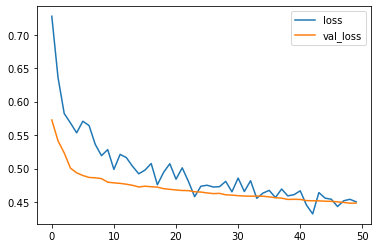

In [191]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

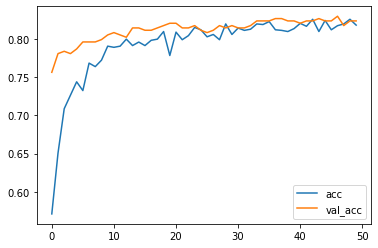

In [192]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [193]:
pred_test = model.predict(X_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[116,  32],
       [ 26, 154]], dtype=int64)

In [194]:
model.save('DNN_F3_model_01')

INFO:tensorflow:Assets written to: DNN_F3_model_01\assets


In [206]:
result_list = []
random = [12,100,6,20,72]
for k in random:
    Xt = addenv_factor2[['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
           'current_rate', 'quick_rate', 'cash_reinvest_rate', 'roe_rate',
           'roa_rate', 'foreign_rate_bys', 'avg_import_rate', 'avg_export_rate',
           'export_kgm_weight_37050000306', 'new_cases_smoothed_USA',
           'new_cases_smoothed_TWN']]

    y1 = Roe_rul['roe_rate1']

    Xt_scaled = pd.DataFrame()
    a, b = Xt.shape

    for i in range(b):
        xt_new = mean_norm(Xt[Xt.columns[i]])
        Xt_scaled.insert(i,Xt.columns[i],xt_new)


    #分割資料為 測試集 與 訓練集
    Xt_train, Xt_test, y1_train, y1_test = train_test_split(Xt_scaled, y1, test_size=0.2, random_state=k)
    N, D = Xt_train.shape

    for x in range(1,6):
        
        # 建立 DNN 模型
        modelt = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(D,)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.6),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.Dense(1, activation='sigmoid')
          ])

        #編譯模型
        modelt.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

#         modelt.summary()

        # 訓練模型
        rt = modelt.fit(Xt_train, y1_train, validation_data=(Xt_test, y1_test), epochs=50, verbose = 0 )
        pred = modelt.predict(Xt_test)
        P = np.round(pred).flatten()
        tmp = [str(k)]
        tmp.extend(modelt.evaluate(Xt_train, y1_train))
        tmp.extend(modelt.evaluate(Xt_test, y1_test))
        tmp.append(f1_score(y1_test, P))

        # 評估模型 - evaluate() returns loss and accuracy
        print("Train score:", modelt.evaluate(Xt_train, y1_train))
        
        print("Test score:", modelt.evaluate(Xt_test, y1_test))
        print("f1_score:",f1_score(y1_test, P))
        result_list.append(tmp)

#         plt.plot(rt.history['loss'], label='loss')
#         plt.plot(rt.history['val_loss'], label='val_loss')
#         plt.legend()
#         plt.savefig(f'./results/pre1_loss_{import_list[item]}_{i}.png')#儲存圖片
#         plt.show() 

#         plt.plot(rt.history['accuracy'], label='acc')
#         plt.plot(rt.history['val_accuracy'], label='val_acc')
#         plt.legend()
#         plt.savefig(f'./results/pre1_accuracy_{import_list[item]}_{i}.png')#儲存圖片
#         plt.show() 

result_pd = pd.DataFrame(result_list,columns=["random_state","train_loss","train_accuracy","test_loss","test_accuracy","F1_score"])
result_pd.to_csv("./results/F1_all_random_test_02.csv")

41/41 [==============================] - 0s 634us/step - loss: 0.3851 - accuracy: 0.8413
Train score: [0.385126531124115, 0.8413425087928772]
11/11 [==============================] - 0s 879us/step - loss: 0.4104 - accuracy: 0.8201
Test score: [0.4103618860244751, 0.8201219439506531]
f1_score: 0.8383561643835616
41/41 [==============================] - 0s 732us/step - loss: 0.3832 - accuracy: 0.8406
Train score: [0.38320842385292053, 0.8405796885490417]
11/11 [==============================] - 0s 781us/step - loss: 0.4104 - accuracy: 0.8049
Test score: [0.4103763997554779, 0.8048780560493469]
f1_score: 0.8315789473684212
41/41 [==============================] - 0s 659us/step - loss: 0.3824 - accuracy: 0.8368
Train score: [0.3823728561401367, 0.8367658257484436]
11/11 [==============================] - 0s 878us/step - loss: 0.4072 - accuracy: 0.8110
Test score: [0.40723708271980286, 0.8109756112098694]
f1_score: 0.835978835978836
41/41 [==============================] - 0s 634us/step - l

11/11 [==============================] - 0s 781us/step - loss: 0.3731 - accuracy: 0.8476
Test score: [0.3731452524662018, 0.8475610017776489]
f1_score: 0.8641304347826086
41/41 [==============================] - 0s 609us/step - loss: 0.3839 - accuracy: 0.8421
Train score: [0.38387852907180786, 0.8421052694320679]
11/11 [==============================] - 0s 878us/step - loss: 0.3726 - accuracy: 0.8506
Test score: [0.3725730776786804, 0.8506097793579102]
f1_score: 0.8650137741046833
41/41 [==============================] - 0s 610us/step - loss: 0.3881 - accuracy: 0.8360
Train score: [0.38809698820114136, 0.8360030651092529]
11/11 [==============================] - 0s 879us/step - loss: 0.3644 - accuracy: 0.8628
Test score: [0.3643856942653656, 0.8628048896789551]
f1_score: 0.8753462603878116
41/41 [==============================] - 0s 560us/step - loss: 0.3929 - accuracy: 0.8330
Train score: [0.39293918013572693, 0.8329519629478455]
11/11 [==============================] - 0s 781us/step 

In [204]:
result_list = []
random = [6,12,100,20,72]
for k in random:
    Xt = addenv_factor2[['net_profit_rate','operating_gross_rate', 'roe_rate','roa_rate',
                    'current_rate', 'quick_rate',  'debt_rate',  'receivables_turnover_rate', 
                    'cash_reinvest_rate','export_usd_value_381800','new_cases_smoothed_TWN',
                     'import_usd_value_37079090','avg_import_rate']]

    y1 = Roe_rul['roe_rate1']

    Xt_scaled = pd.DataFrame()
    a, b = Xt.shape

    for i in range(b):
        xt_new = mean_norm(Xt[Xt.columns[i]])
        Xt_scaled.insert(i,Xt.columns[i],xt_new)


    #分割資料為 測試集 與 訓練集
    Xt_train, Xt_test, y1_train, y1_test = train_test_split(Xt_scaled, y1, test_size=0.2, random_state=k)
    N, D = Xt_train.shape

    for x in range(1,6):
        
        # 建立 DNN 模型
        modelt = tf.keras.models.Sequential([
          tf.keras.layers.Input(shape=(D,)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.8),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dropout(0.6),
          tf.keras.layers.Dense(1, activation='sigmoid')
          ])

        #編譯模型
        modelt.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

#         modelt.summary()

        # 訓練模型
        rt = modelt.fit(Xt_train, y1_train, validation_data=(Xt_test, y1_test), epochs=50, verbose = 0 )
        pred = modelt.predict(Xt_test)
        P = np.round(pred).flatten()
        tmp = [str(k)]
        tmp.extend(modelt.evaluate(Xt_train, y1_train))
        tmp.extend(modelt.evaluate(Xt_test, y1_test))
        tmp.append(f1_score(y1_test, P))

        # 評估模型 - evaluate() returns loss and accuracy
        print("Train score:", modelt.evaluate(Xt_train, y1_train))
        print("Test score:", modelt.evaluate(Xt_test, y1_test))
        print("f1_score:",f1_score(y1_test, P))
        result_list.append(tmp)

#         plt.plot(rt.history['loss'], label='loss')
#         plt.plot(rt.history['val_loss'], label='val_loss')
#         plt.legend()
#         plt.savefig(f'./results/pre1_loss_{import_list[item]}_{i}.png')#儲存圖片
#         plt.show() 

#         plt.plot(rt.history['accuracy'], label='acc')
#         plt.plot(rt.history['val_accuracy'], label='val_acc')
#         plt.legend()
#         plt.savefig(f'./results/pre1_accuracy_{import_list[item]}_{i}.png')#儲存圖片
#         plt.show() 

result_pd = pd.DataFrame(result_list,columns=["random_state","train_loss","train_accuracy","test_loss","test_accuracy","F1_score"])
result_pd.to_csv("./results/F3_all_random_test_01.csv")

41/41 [==============================] - 0s 464us/step - loss: 0.4250 - accuracy: 0.8314
Train score: [0.4249718189239502, 0.8314263820648193]
11/11 [==============================] - 0s 586us/step - loss: 0.3820 - accuracy: 0.8567
Test score: [0.3820338547229767, 0.8567073345184326]
f1_score: 0.8719346049046323
41/41 [==============================] - 0s 659us/step - loss: 0.4219 - accuracy: 0.8322
Train score: [0.42191624641418457, 0.83218914270401]
11/11 [==============================] - 0s 976us/step - loss: 0.3752 - accuracy: 0.8567
Test score: [0.375216007232666, 0.8567073345184326]
f1_score: 0.8698060941828254
41/41 [==============================] - 0s 512us/step - loss: 0.4191 - accuracy: 0.8307
Train score: [0.41908061504364014, 0.8306636214256287]
11/11 [==============================] - 0s 779us/step - loss: 0.3765 - accuracy: 0.8659
Test score: [0.3765416741371155, 0.8658536672592163]
f1_score: 0.8835978835978837
41/41 [==============================] - 0s 537us/step - lo